In [48]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import statistics
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt

sc = StandardScaler()

In [49]:
df = pd.read_csv('weather_classification_data.csv') 
df[:5]

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


In [50]:
temp = pd.get_dummies(df['Cloud Cover'],dtype=int)
df.drop(['Cloud Cover'],axis=1,inplace=True)
df=pd.concat([df,temp],axis=1)
temp = pd.get_dummies(df['Season'],dtype=int)
df.drop(['Season'],axis=1,inplace=True)
df=pd.concat([df,temp],axis=1)
temp = pd.get_dummies(df['Location'],dtype=int)
df.drop(['Location'],axis=1,inplace=True)
df=pd.concat([df,temp],axis=1)
y=df['Weather Type']
df.drop(['Weather Type'],axis=1,inplace=True)
x=df.copy()

In [51]:
y=pd.Series(y)
temp = pd.get_dummies(y,dtype=int)
y=pd.concat([y,temp],axis=1)
y.drop(['Weather Type'],axis=1,inplace=True)

In [52]:
y[:5]

,Cloudy,Rainy,Snowy,Sunny
0,0,1,0,0
1,1,0,0,0
2,0,0,0,1
3,0,0,0,1
4,0,1,0,0


In [53]:
x[:5]

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),clear,cloudy,overcast,partly cloudy,Autumn,Spring,Summer,Winter,coastal,inland,mountain
0,14.0,73,9.5,82.0,1010.82,2,3.5,0,0,0,1,0,0,0,1,0,1,0
1,39.0,96,8.5,71.0,1011.43,7,10.0,0,0,0,1,0,1,0,0,0,1,0
2,30.0,64,7.0,16.0,1018.72,5,5.5,1,0,0,0,0,1,0,0,0,0,1
3,38.0,83,1.5,82.0,1026.25,7,1.0,1,0,0,0,0,1,0,0,1,0,0
4,27.0,74,17.0,66.0,990.67,1,2.5,0,0,1,0,0,0,0,1,0,0,1


In [54]:
x = sc.fit_transform(X=x)
y = sc.fit_transform(X=y)
Xtrain,Xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2,random_state=42)
Xtest,Xval,ytest,yval = train_test_split(Xtest,ytest,test_size=0.5,random_state=42)


In [55]:
class Customdataset(Dataset):
    def __init__(self,a,b):
        self.x=torch.tensor(a,dtype=torch.float32)
        self.y=torch.tensor(b,dtype=torch.float32)

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index],self.y[index]
    
traindataset=Customdataset(a=Xtrain,b=ytrain)
valdataset=Customdataset(a=Xval,b=yval)
testdataset=Customdataset(a=Xtest,b=ytest)

traindl=DataLoader(traindataset,batch_size=16,shuffle=True)
testdl=DataLoader(testdataset,batch_size=16,shuffle=True)
valdl=DataLoader(valdataset,batch_size=16,shuffle=True)

In [59]:
class Classification(nn.Module):
    def __init__(self):
        super(Classification,self).__init__()
        self.Linear1=nn.Linear(x.shape[1],10)
        self.Linear2=nn.Linear(10,y.shape[1])
            
    def forward(self,x):
        x=self.Linear1(x)
        x=torch.relu(x)
        x=self.Linear2(x)
        return x
model=Classification()
critetion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=1e-3)


In [60]:
train_acc,train_loss=[],[]
val_acc,val_loss=[],[]
epoches = 2
for i in range(epoches):
    l1,l2=0,0
    model.train()
    ta,tl=[],[]
    for values,labels in traindl:
        labels=torch.argmax(labels,dim=1)
        ypred = model(values)
        tloss = critetion(ypred,labels)
        optimizer.zero_grad()
        tloss.backward()        
        optimizer.step()
        l1=labels.unsqueeze(1)
        ypred=torch.argmax(ypred,dim=1) 
        tl.append(int(tloss.detach().numpy()))
        ta.append(precision_score(l1.cpu().numpy(),ypred.cpu().numpy(),average='macro'))
    train_acc.append(statistics.mean(ta))
    train_loss.append(statistics.mean(tl))
    # print('trian')
    # print(mean_absolute_error(l1,ypred.detach().numpy()))  
    # print(tloss)
    va,vl = [],[]
    model.eval()   
    with torch.no_grad():
        for values,labels in valdl:
            labels=torch.argmax(labels,dim=1)
            ypred = model(values)
            tloss = critetion(ypred,labels)
            l2=labels.unsqueeze(1)
            ypred=torch.argmax(ypred,dim=1) 
            vl.append(int(tloss.detach().numpy()))
            va.append(precision_score(l2.cpu().numpy(),ypred.cpu().numpy(),average='macro'))
        val_acc.append(statistics.mean(va))
        val_loss.append(statistics.mean(vl))
        # print('test')
        # print(mean_absolute_error(l2,ypred.detach().numpy()))
        # print(tloss)

c:\Users\ASUS\.conda\envs\PyTorch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\.conda\envs\PyTorch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\.conda\envs\PyTorch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS

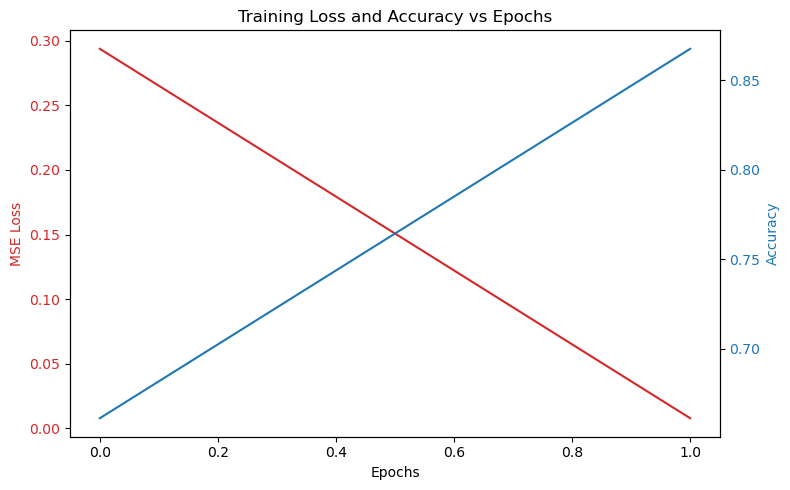

In [61]:
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.plot(range(epoches), train_loss, color='tab:red', label='Loss')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("MSE Loss", color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax2 = ax1.twinx()
ax2.plot(range(epoches), train_acc, color='tab:blue', label='Accuracy')
ax2.set_ylabel("Accuracy", color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')
plt.title("Training Loss and Accuracy vs Epochs")
fig.tight_layout()
plt.show()